# Rotations

In this notebook, the NN learns learns the 2d rotation matrix, parameterized by the generator of rotations in two dimensions:

$R={\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \\\end{bmatrix}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import torch
import torch.nn as nn
from torch.autograd import Variable

cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c
plt.style.use('ggplot')

%matplotlib notebook
%matplotlib notebook

In [2]:
%matplotlib notebook

In [84]:
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(3,1000,bias=True),
            nn.LeakyReLU(),
            nn.Linear(1000,1000,bias=False),
            nn.LeakyReLU(),
            nn.Linear(1000,1000,bias=False),
            nn.LeakyReLU(),
            nn.Linear(1000,1000,bias=False),
            nn.LeakyReLU(),
            nn.Linear(1000,2,bias=False))
        
    def forward(self, x):
        out = self.layer1(x)
        return out

In [85]:
model = Rotations()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-4)
criterion = nn.SmoothL1Loss()
total_loss = []

In [86]:
model

Rotations(
  (layer1): Sequential(
    (0): Linear(in_features=3, out_features=1000, bias=True)
    (1): LeakyReLU(0.01)
    (2): Linear(in_features=1000, out_features=1000, bias=False)
    (3): LeakyReLU(0.01)
    (4): Linear(in_features=1000, out_features=1000, bias=False)
    (5): LeakyReLU(0.01)
    (6): Linear(in_features=1000, out_features=1000, bias=False)
    (7): LeakyReLU(0.01)
    (8): Linear(in_features=1000, out_features=2, bias=False)
  )
)

In [87]:
%%time

num_samples = 100000
for k in range(num_samples):
    
    # =================== data calc ===================
    x = torch.randn(2)
    theta = 10*torch.rand(1)
    data = torch.cat((x,theta))
    
    R = torch.zeros(2,2)
    R[0,:] = torch.Tensor([np.cos(theta[0]),-np.sin(theta[0])])
    R[1,:] = torch.Tensor([np.sin(theta[0]), np.cos(theta[0])])

    data, target = Variable(data).cuda(), Variable(torch.mv(R,x)).cuda()
    
    # =================== forward =====================
    output = model(data)
    loss   = criterion(output, target)

    # =================== backward ====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # =================== log ========================
    total_loss.append(loss.data[0])
    if (k+1)%(num_samples//10)==0:
        print('[{}] loss: {:.5f}'
              .format(k+1, total_loss[-1]))

[10000] loss: 0.52295
[20000] loss: 0.05325
[30000] loss: 0.00530
[40000] loss: 0.02865
[50000] loss: 0.00128
[60000] loss: 0.00846
[70000] loss: 0.02597
[80000] loss: 0.00256
[90000] loss: 0.00403
[100000] loss: 0.00024
CPU times: user 2min 48s, sys: 21.1 s, total: 3min 9s
Wall time: 3min 9s


<IPython.core.display.Javascript object>


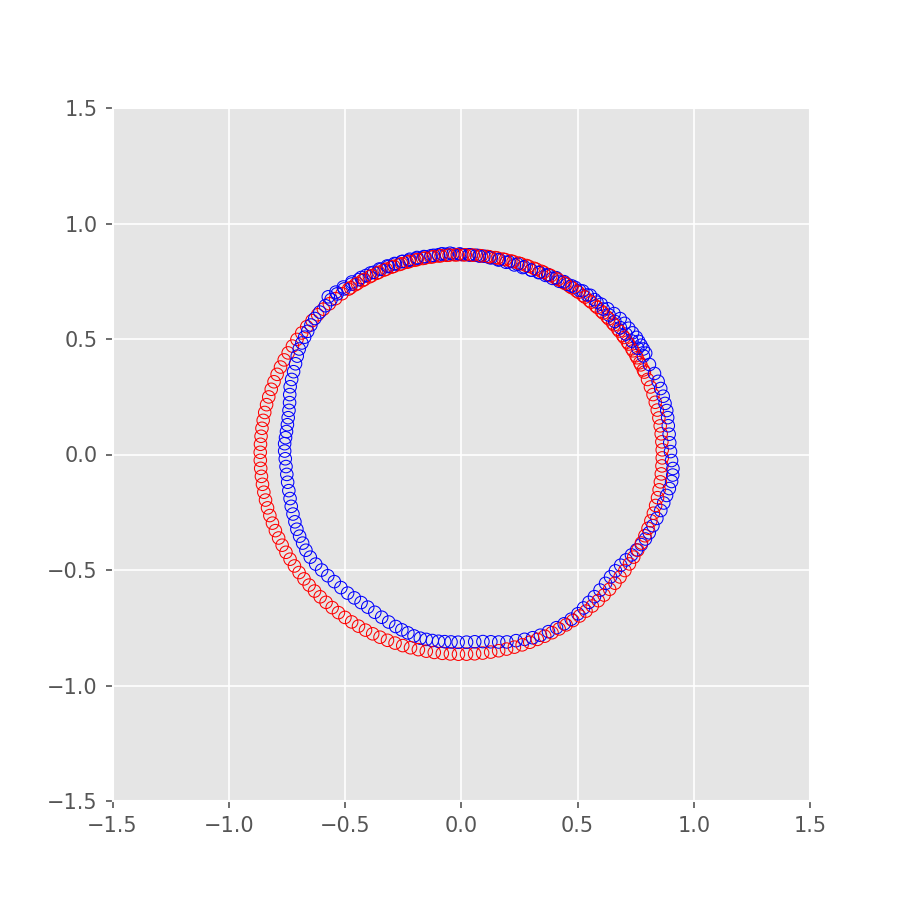

In [91]:
fig, ax = plt.subplots(figsize=(6,6))

x = torch.rand(2)
theta = 0.1
data = Variable(torch.Tensor([x[0],x[1],theta])).cuda()

for theta in np.linspace(0,8,200):
    data   = Variable(torch.Tensor([x[0],x[1],theta])).cuda()
    output = model(data)
    
    R = torch.zeros(2,2)
    R[0,:] = torch.Tensor([np.cos(theta),-np.sin(theta)])
    R[1,:] = torch.Tensor([np.sin(theta), np.cos(theta)])

    real = torch.mv(R,x)
    modeld = output.data
    
    ax.scatter(real[0],real[1], facecolors='none', edgecolors='r')
    ax.scatter(modeld[0],modeld[1], facecolors='none', edgecolors='b')
    
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.5,1.5);

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))